In [35]:
# This notebook is aimed to deal with the transiant state, specifically the "easy" data

In [36]:
from DataPrepocessing import *
from NeuralNets import *
from TrainMethod import *

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler

### Some pre-defined parameters

In [37]:
sequence_length = 20
batch_size = 16

In [38]:
# first,read the data and do some data analysis

### Do the data prepocessing

In [39]:
first_run = pd.read_csv('./data/tracked_Cs137_990_easy.csv', index_col = 0)
second_run = pd.read_csv('./data/tracked_Cs137_1308_easy.csv', index_col = 0)
first_cycle = pd.read_csv('./data/tracked_Cs137_1308_easy.csv', index_col = 0)
P1T1_to_P06T1 = pd.read_csv('./transiant_data/P1T1_to_P0.6T1.csv', index_col= 0)

In [40]:
def process(df):
    # read in a pandas frame, remove the keff_relative_uncertainty and keff_absolute_uncertainty
    # return the keff and the data columns

    df = df.drop('keff_relative_uncertainty',axis = 1)
    df = df.drop('keff_absolute_uncertainty', axis = 1)

    keff = df.pop('keff')

    # print(type(df))

    return keff, df

In [41]:
def generate_histogram(data: np.ndarray, binInt = 1.0e-06, binMax = 1.5e-04):
    '''
    Take in a data with columns are features  Transform the features with histogram method
    '''

    # Extract data
    Xvals = data

    nRows, nCols = Xvals.shape

    # define bins
    hEdges = np.arange(0, binMax+binInt, binInt)
    nBins = len(hEdges)-1


    # fill histogram matrix
    nCountsX = np.zeros((nRows, nBins), dtype=np.uint16)
    for n in range(nRows):
        nCountsX[n,:], _ = np.histogram(Xvals[n,:], hEdges)
    return nCountsX

In [42]:
'''
a reminder, shoule we remove the first column since all cs is 0?
'''

'\na reminder, shoule we remove the first column since all cs is 0?\n'

In [43]:
tracked_file = pd.read_csv('./data/cycle_990_easy.csv', index_col= 0)
tracked_file.columns

Index(['time', 'passes', 'recirculated', 'discarded', 'keff',
       'keff_relative_uncertainty', 'keff_absolute_uncertainty',
       'neutrons_per_cycle', 'power_normalization_value', 'DEM_step_increment',
       'threshold', 'time_step'],
      dtype='object')

In [44]:
power = tracked_file['power_normalization_value'] / 1e7
threshold = tracked_file['threshold'] / 72

In [45]:
def add_Power_and_Threshold(all_data, tracked_filename):

    tracked_file = pd.read_csv(tracked_filename, index_col= 0)
    
    power = tracked_file['power_normalization_value'] / 1e7
    threshold = tracked_file['threshold'] / 72
    
    power = power.to_numpy()[:-1]
    threshold = threshold.to_numpy()[:-1]
    
    
    all_data = np.insert(all_data, 0, power, axis=1)
    all_data = np.insert(all_data, 0, threshold, axis=1)
    
    return all_data

In [46]:
# combine all the above step

def get_data(filename, tracked_filename):
    df = pd.read_csv(filename, index_col= 0)

    keff, data = process(df)
    hist_data = generate_histogram(data.to_numpy())

    # delete the fist element in keff

    keff = keff.to_numpy()
    keff = keff[1:]
    # print(keff.shape)

    # delete the last row in hist_data

    hist_data = hist_data[:-1]
    # print(hist_data.shape)

    all_data = np.append(hist_data, keff.reshape(-1,1), axis=1)
    
    all_data = add_Power_and_Threshold(all_data, tracked_filename)


    all_data = all_data[: len(all_data)//sequence_length * sequence_length]



    return all_data
    


In [47]:
first_run = get_data('./data/tracked_Cs137_990_easy.csv', './data/cycle_990_easy.csv')
second_run = get_data('./data/tracked_Cs137_1308_easy.csv','./data/cycle_1308_easy.csv')

In [50]:
np.savetxt('first_run.csv', first_run, delimiter= ',')

np.savetxt('second_run.csv', second_run, delimiter =  ',')



In [ ]:
raise KeyError()

In [ ]:
P1T1_to_P06T1.shape

(350, 837)

In [ ]:
# concentrate all data together and do the standarlize
add_order = [P1T1_to_P06T1,P1T1_to_P08T1,P1T1_to_P1T11,P1T1_to_P1T09]
all_data = np.concatenate(add_order, axis=0)
all_data.shape

NameError: name 'P1T1_to_P08T1' is not defined

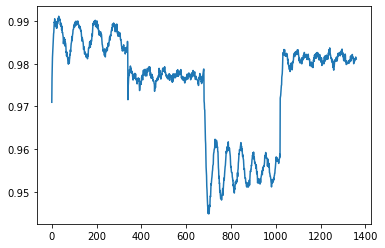

In [ ]:
plt.plot(all_data[:,-1])

### Add stable data

In [ ]:
# then, we need to add the stable data to the training set
stable_data = np.loadtxt('stable_data.csv', delimiter= ',', dtype= np.float64)
print(stable_data.shape)

(1600, 153)


In [ ]:
all_data = np.concatenate([all_data, stable_data], axis = 0)

### Do the standarlize

In [ ]:
data = all_data

ss = StandardScaler()

data = ss.fit_transform(data)


clean_data = data.copy()

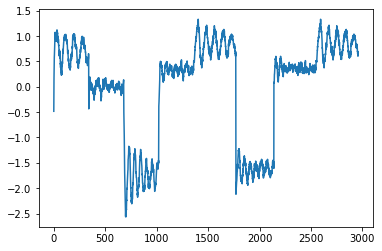

In [ ]:
plt.plot(data[:,-1])

In [ ]:
# define the training and testing set
training_data = ReactorData(data,sequence_length,0,0.65)


testing_data = ReactorData(data,sequence_length,0.65,1)

training_and_testing_data = ReactorData(data,sequence_length,0,1)

### Training 

In [ ]:
# define neural nets

input_dim = training_data[0][0].shape[1]



# print(output_dim)

# some adjustable hyper-parameters
nets_hyper_parameters = {
'input_dim' : input_dim,
'output_dim' : 1,
'hidden_dim' : 256,
'lstm_nums_layer' : 2,
'dropout' : 0.2 
}


model = SimpleLSTM(**nets_hyper_parameters)

In [ ]:
optimizer_parameters = {
    'params':model.parameters(),
    'lr' : 0.005,
    'weight_decay' : 0.005
    #'amsgrad' : True
}
# 

train_parameters = {
    'model' : model,
    'training_data' : training_data,
    'epoch_num': 200,
    'batch_size':batch_size,
    'optimizer' : optim.Adam(**optimizer_parameters),
    'loss_fn' : nn.MSELoss(),
    'print_out_frequency': 20,
    'shuffle': True

}


model, _ = train(** train_parameters)

The loss is 0.4730136445086089 in epoch 0
The loss is 0.05456009539546406 in epoch 20
The loss is 0.03968141016384755 in epoch 40
The loss is 0.053577424800073915 in epoch 60
The loss is 0.044037457292342555 in epoch 80
The loss is 0.05056255246393576 in epoch 100
The loss is 0.05655691020469931 in epoch 120
The loss is 0.03047041284377277 in epoch 140
The loss is 0.03409566847776166 in epoch 160
The loss is 0.030415735153069823 in epoch 180
Training is finished, the final loss is 0.031777302799077985


### Visualize the training result

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def eval(data, batch_size, sequence_length):
    # Assuming you have a DataSet object called 'training_data' and a trained model called 'model'
    training_set = data
    # Step 1: Create a DataLoader from your DataSet object
    batch_size = batch_size  # Adjust this value based on your model's input requirements
    train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=False)

    # Step 2 & 3: Iterate through the DataLoader and collect predictions and true labels
    predictions = []
    true_labels = []

    sequence_length = sequence_length  # Assuming a sequence length of 10

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in train_loader:
            # Pass the input data to the trained model and collect the predictions
            preds = model(inputs)
            preds = preds.reshape(-1, sequence_length)  # Reshape the predictions to (batch_size, sequence_length, output_dim)
            predictions.extend(preds.squeeze().view(-1).tolist())  # Flatten the predictions
            true_labels.extend(labels.squeeze().view(-1).tolist())  # Flatten the true labels

    # Step 4: Plot the predictions and true labels for comparison
    loss = nn.MSELoss()
    tensor1 = torch.tensor(predictions)
    tensor2 = torch.tensor(true_labels)
    test_loss = loss(tensor1, tensor2)
    print(test_loss)
    plt.figure()
    plt.xlabel('Timestamp')
    plt.ylabel('Keff')
    plt.plot(true_labels, label="Real")
    plt.plot(predictions, label="Predict", alpha = 0.7)
    plt.legend()
    plt.show()

    return np.array(true_labels), np.array(predictions)


tensor(0.0348)


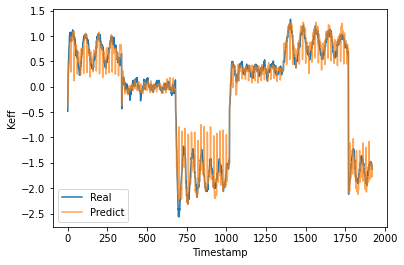

In [ ]:
training_label, training_pred =  eval(training_data, batch_size, sequence_length)

tensor(0.0361)


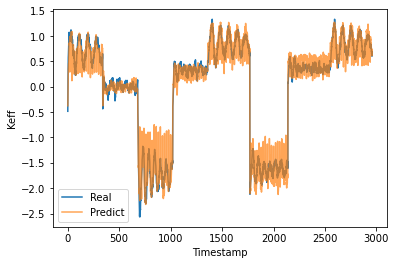

In [ ]:
all_label, all_pred =  eval(training_and_testing_data, batch_size, sequence_length)

tensor(0.0383)


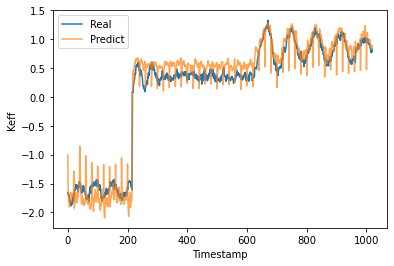

In [ ]:
all_label, all_pred =  eval(testing_data, batch_size, sequence_length)

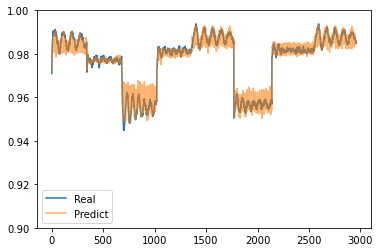

In [ ]:
# change to the original unit
true_labels = all_label
predictions = all_pred
X = training_and_testing_data.unshaped_data

result_y = np.append(X, true_labels.reshape(-1,1), axis=1)
result_predict = np.append(X, predictions.reshape(-1,1), axis=1)

y = ss.inverse_transform(result_y)
predict = ss.inverse_transform(result_predict)

plt.figure()
plt.ylim((0.9,1))
plt.plot(y[:,-1], label = "Real")     
plt.plot(predict[:,-1], label = "Predict", alpha = 0.6)
plt.legend()


In [ ]:
### Fine tuning hyperparameters

In [ ]:
# will do this later, specifically wrapping training and evaluation into functions and fine tuning like that

In [ ]:
'''
some points

should add some stable data?
should increse model size?
should do some more data prepocessing?
should use pre-trained model?
'''

'\nsome points\n\nshould add some stable data?\nshould increse model size?\nshould do some more data prepocessing?\nshould use pre-trained model?\n'